# Setup

In [1]:
# Import packages
import os
import re
import sys
import json
import string
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

In [2]:
# Globals
BUFFER_SIZE = 5000
BUFFER_BATCH_SIZE = 64
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 512
EMBEDDING_DIM = 128

# Setup input pipeline

In [3]:
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]
print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [4]:
# View some examples from train
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# View some examples from test
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'Why do all movies on Lifetime have such anemic titles? "An Unexpected Love" - ooh, how provocative!! "This Much I know" would have been better. The film is nothing special. Real people don\'t really talk like these characters do and the situations are really hackneyed. The straight woman who "turns" lesbian seemed more butch than the lesbian character. If you wanna watch two hot women kiss in a very discreet fashion, you might enjoy this. Although it seems like it was written by someone who doesn\'t really get out in the world to observe people. Why am I wasting my time writing about it?', shape=(), dtype=string)


# Data processing

In [8]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML).
# We will need to create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [9]:
encoder = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

# Adapt to train text
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'Insisting that Martin Luther King\'s inspirational spirit resides not just in American civil liberties but inside the hearts and minds of people everywhere, Danish helmer Niels Arden Oplev transplants this belief to a 1969 Danish middle school. More specifically, it works its way into the crusade of a young boy named Frits (Janus Dissing Rathke) against his oppressively rigid and churlishly abusive headmaster Svendsen (Bent Mejding). Adapted from a true story, the performances are executed with certain aplomb and a refreshing command over its varied characters keeps it involving. A battle of ideologies between a 13 year-old and a demented disciplinarian gives way to inherent humour but awkward shifts in mood disorients despite keeping it shrewdly cynical in the same vein as a "Dead Poets Society" more than a "Matilda". It treads a familiar path but a continued and precise service to its young protagonist including a personal subplot that rounds off Frits as a young boy beco

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the data.
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

# Modelling

In [12]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.Dropout(0.3)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

# We create a model object
model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [14]:
# Train and validate model on sub-sample from test dataset
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = test_dataset,
    validation_steps = 10,
    callbacks = callbacks
)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4787 - accuracy: 0.7370 - val_loss: 0.2841 - val_accuracy: 0.8797
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.2419 - accuracy: 0.9048 - val_loss: 0.2507 - val_accuracy: 0.8922
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 0.1591 - accuracy: 0.9404 - val_loss: 0.3636 - val_accuracy: 0.8797
Epoch 4/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0937 - accuracy: 0.9691 - val_loss: 0.3831 - val_accuracy: 0.8844
Epoch 5/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.5584 - val_accuracy: 0.8797


In [15]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print("Test loss;", test_loss)
print("Test accuracy:", test_acc)

391/391 [==============================] - 3s 8ms/step - loss: 0.5188 - accuracy: 0.8707
Test loss; 0.518839955329895
Test accuracy: 0.8706799745559692


# Visualize model performance

In [16]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

(0.0, 0.5835400942713023)

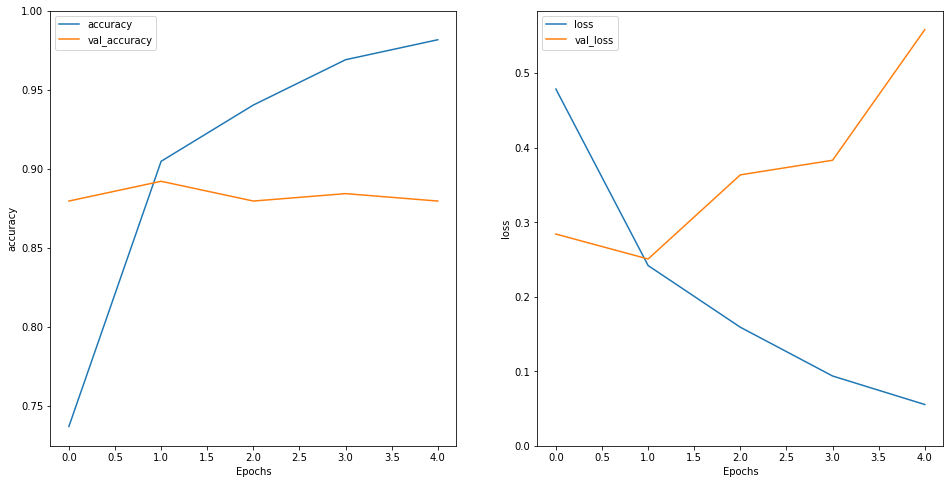

In [17]:
# Create a figure
plt.figure(figsize=(16,8))

# Plot accuracy graph
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None,1)

# Plot loss graph
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)